In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
# Load packages
import logging
import pickle
import os

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import plotly.io as pio


In [3]:
PATH = '../data/processed/processed_data.pkl'
REPORT_PATH = '../reports/figures/'

ROLE_COLS      = ['DevType']
SkILLS_COLS      = ['Language',
                  'Database',
                  'Platform',
                  'Web Framework',
                  'Miscellaneous Tech',
                  'Developer Tools',
                  ]


In [4]:
df = pd.read_pickle(PATH)


In [22]:
countries = df.groupby(['Country'])['Country'].count().sort_values(ascending=False)
#countries.iloc[:50].plot(kind='bar', figsize=(10,5))
fig = px.scatter_geo(
    countries,
    locations=countries.index,  # DataFrame column with locations
    locationmode='country names',
    size=countries.values,  # Size of bubbles
    color=countries.values,  # Color of bubbles
    hover_name=countries.index,  # Text to display on hover
    projection='natural earth',  # Choose a map projection
    title='Distribution of respondents by country',  # Title of plot
)

# Show the plot
fig.show()
# Save the figure as a PNG file
pio.write_image(fig, REPORT_PATH+'maps.png')

The above map shows the distribution of the number of survey take in each country. USA has the most number of survey taken, followed by Europe and India. Australia and Brazil have a comparable number of survey taken. The rest of the countries have a very small number of survey taken.

<Axes: xlabel='EdLevel'>

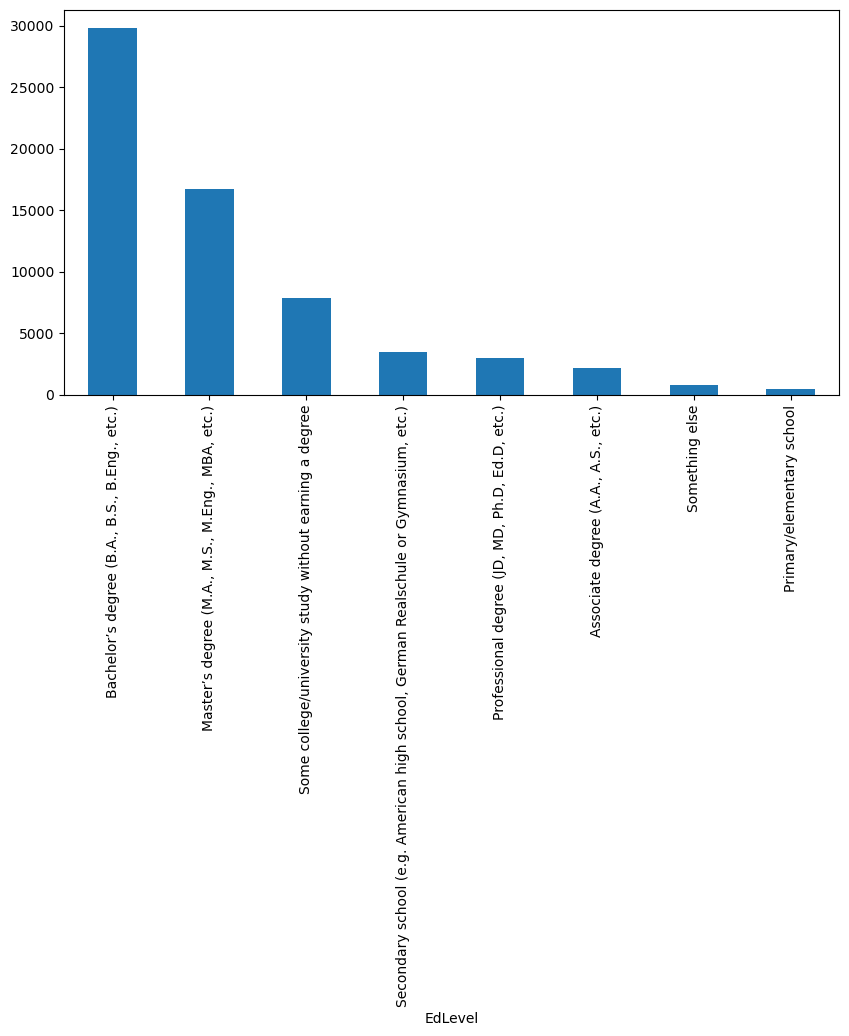

In [6]:
df.groupby(['EdLevel'])['EdLevel'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

In [7]:
df['EdLevel'] = df['EdLevel'].fillna("")
df['EdLevel'] = [item.split(';') if item else [] for item in df['EdLevel']]



encoded_dfs = {}
for col in ROLE_COLS + SkILLS_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                               columns=binarizer.classes_,
                               index=df[col].index)
                               
    encoded_dfs[col] = encoded_df

In [8]:
encoded_df = pd.concat(encoded_dfs, axis=1)
encoded_df['Country'] = df['Country']   
encoded_df

DevType                                           \
      Academic researcher Blockchain Cloud infrastructure engineer   
0                       0          0                             0   
1                       0          0                             0   
2                       0          0                             0   
3                       0          0                             0   
4                       0          0                             0   
...                   ...        ...                           ...   
64333                   0          0                             0   
64334                   0          0                             0   
64335                   0          0                             0   
64336                   0          0                             0   
64337                   0          0                             0   

                                                                              \
      Data or business analyst Data scientist or machine learning specialist   
0                            0                                             0   
1                            0                                             0   
2                            0                                             0   
3                            0                                             0   
4                            0                                             0   
...                        ...                                           ...   
64333                        0                                             0   
64334                        0                                             0   
64335                        0                                             0   
64336                        0                                             0   
64337                        0                                             0   

                                                                      \
      Database administrator DevOps specialist Developer, QA or test   
0                          0                 0                     0   
1                          0                 0                     0   
2                          0                 0                     0   
3                          0                 0                     0   
4                          0                 0                     0   
...                      ...               ...                   ...   
64333                      0                 0                     0   
64334                      0                 0                     0   
64335                      0                 0                     0   
64336                      0                 0                     0   
64337                      0                 0                     0   

                                                                         ...  \
      Developer, back-end Developer, desktop or enterprise applications  ...   
0                       1                                             0  ...   
1                       0                                             0  ...   
2                       0                                             0  ...   
3                       1                                             0  ...   
4                       0                                             0  ...   
...                   ...                                           ...  ...   
64333                   0                                             0  ...   
64334                   0                                             0  ...   
64335                   1                                             0  ...   
64336                   0                                             0  ...   
64337                   0                                             0  ...   

      Developer Tools                                                     \
            

In [23]:
import plotly.express as px

countries_df ={}
for country in df.Country.value_counts()[:9].index:
    jobs_freq = encoded_df[encoded_df['Country'] == country]['DevType'].sum().rename('count').sort_values(ascending=False).reset_index()
    jobs_freq['count'] = jobs_freq['count']/jobs_freq['count'].sum() * 100
    countries_df[country] = jobs_freq

jobs_freq_df = pd.concat(countries_df, axis=0).reset_index().drop('level_1', axis=1)

jobs_freq_df.columns = ['nation', 'job', 'count']
fig = px.bar(jobs_freq_df, x="nation", y="count", color="job", title="Long-Form Input", barmode='stack', height=800)
fig.show()
pio.write_image(fig, REPORT_PATH+'job_distribution.png', width=1000, height=800)

In [26]:
for country in df.Country.value_counts()[:5].index:
    skills_freq = encoded_df[encoded_df['Country'] == country].drop(['Country','DevType'], axis=1).sum().reset_index()
    skills_freq.columns = ['group', 'skill', 'freq']
    skills_freq.sort_values('freq', ascending=False)
    skills_freq.freq = skills_freq.freq + 1

    fig = px.treemap(skills_freq, 
                 path=['group', 'skill'], 
                 color_continuous_scale='viridis',
                 values='freq',color='freq')

    fig.update_layout(width=1000, height=700, title=f"Skills of {country} respondents")
    fig.show()
    pio.write_image(fig, REPORT_PATH+  f"{country}-skills_distribution.png", width=1000, height=800)

<Axes: title={'center': 'Number of skills per respondent'}, ylabel='Frequency'>

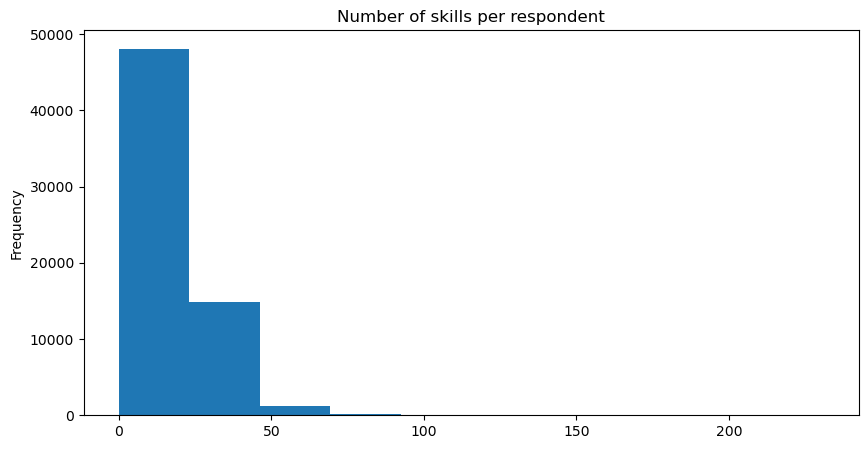

In [11]:
encoded_df[SkILLS_COLS].sum(axis=1).plot(kind='hist', figsize=(10,5), title='Number of skills per respondent')

In [12]:
encoded_df = encoded_df[(encoded_df[SkILLS_COLS].sum(axis=1) > 2) & (encoded_df[SkILLS_COLS].sum(axis=1) < 25)]

In [13]:
encoded_df.shape

(48998, 254)

## HeatMap

In [14]:
sorted_roles = encoded_df['DevType'].sum().sort_values().index.tolist()

sorted_skills = encoded_df.drop(['DevType', 'Country'], axis=1).sum().sort_values(ascending=False).droplevel(level=0).index.tolist()
sorted_roles

['Database administrator',
 'Blockchain',
 'Hardware Engineer',
 'Scientist',
 'Engineer, site reliability',
 'Security professional',
 'Developer, QA or test',
 'System administrator',
 'Developer, game or graphics',
 'Data or business analyst',
 'Cloud infrastructure engineer',
 'DevOps specialist',
 'Engineer, data',
 'Research & Development role',
 'Academic researcher',
 'Data scientist or machine learning specialist',
 'Developer, embedded applications or devices',
 'Developer, mobile',
 'Developer, desktop or enterprise applications',
 'Developer, front-end',
 'Developer, back-end',
 'Developer, full-stack']

In [15]:
skills = []
for role in sorted_roles:
    skills_role= encoded_df[encoded_df[('DevType', role)]==1].drop(['DevType', 'Country'], axis=1).mean().droplevel(level=0).sort_values(ascending=False) *100
    skills.append(skills_role)

skills = pd.concat(skills, axis=1)
skills.columns = sorted_roles
skills = skills.loc[sorted_skills]
skills = skills.T
skills

,JavaScript,HTML/CSS,SQL,Docker,Python,npm,Amazon Web Services (AWS),PostgreSQL,TypeScript,MySQL,...,Raku,TiDB,build2,APL,lest,tunit,snitch,CUTE,liblittletest,ELFspy
Database administrator,23.222749,27.014218,85.781991,22.748815,40.758294,5.687204,27.962085,28.436019,4.739336,32.701422,...,0.000000,0.947867,0.000000,0.473934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Blockchain,56.542056,29.906542,24.299065,49.065421,33.177570,48.598131,48.598131,47.196262,47.663551,19.626168,...,0.000000,0.000000,0.467290,0.467290,0.467290,0.000000,0.000000,0.000000,0.000000,0.000000
Hardware Engineer,23.364486,25.233645,18.691589,27.102804,75.233645,12.149533,12.616822,11.214953,4.205607,18.224299,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.467290,0.000000,0.000000,0.467290,0.000000
Scientist,21.755725,20.229008,25.190840,26.335878,81.679389,6.106870,19.083969,16.412214,3.816794,21.755725,...,0.381679,0.381679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Engineer, site reliability",36.296296,29.629630,32.222222,66.666667,68.888889,23.333333,60.000000,47.777778,19.259259,27.037037,...,0.370370,0.000000,0.000000,0.000000,0.370370,0.000000,0.000000,0.000000,0.000000,0.000000
Security professional,48.813559,35.932203,34.237288,52.203390,74.915254,26.101695,45.084746,32.881356,15.932203,22.033898,...,0.000000,0.338983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Developer, QA or test",48.931624,32.692308,33.547009,42.521368,57.478632,34.401709,33.547009,27.777778,21.794872,25.854701,...,0.000000,0.213675,0.000000,0.213675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
System administrator,47.478992,46.218487,50.840336,34.873950,54.411765,18.907563,19.537815,33.613445,10.084034,36.974790,...,1.260504,0.000000,0.000000,0.210084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Developer, game or graphics",37.820513,27.884615,12.660256,17.948718,39.903846,20.512821,21.634615,11.378205,20.192308,16.506410,...,0.000000,0.000000,0.320513,0.160256,0.000000,0.000000,0.160256,0.000000,0.000000,0.000000
Data or business analyst,37.898089,38.057325,76.273885,16.719745,68.312102,12.261146,21.019108,29.458599,9.554140,31.687898,...,0.000000,0.000000,0.159236,0.159236,0.159236,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
fig = go.Figure(data=go.Heatmap(z=skills, x=skills.columns,y=skills.index, colorscale='magma', ygap=1))
fig.update_layout(width=1500, height=1000)
fig.show()


## Stadardization of skills

In [17]:
std_skills = StandardScaler().fit_transform(skills)
std_skills = pd.DataFrame(std_skills, columns=skills.columns, index=skills.index)
std_skills

,JavaScript,HTML/CSS,SQL,Docker,Python,npm,Amazon Web Services (AWS),PostgreSQL,TypeScript,MySQL,...,Raku,TiDB,build2,APL,lest,tunit,snitch,CUTE,liblittletest,ELFspy
Database administrator,-0.943071,-0.317174,2.386028,-1.057182,-0.761714,-1.143210,-0.380540,-0.151872,-0.893731,1.303612,...,-0.540757,3.786454,-0.700372,2.632620,-0.512489,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
Blockchain,0.942757,-0.118589,-0.690305,0.512954,-1.111855,1.543387,0.904060,1.274520,1.717417,-0.720435,...,-0.540757,-0.621196,2.241548,2.583521,3.313965,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
Hardware Engineer,-0.935049,-0.439427,-0.970878,-0.797408,0.830645,-0.738612,-1.335788,-1.461236,-0.926198,-0.937444,...,-0.540757,-0.621196,-0.700372,-0.869813,-0.512489,4.236554,-0.516155,-0.504425,4.486574,-0.255916
Scientist,-1.026102,-0.783043,-0.645684,-0.843166,1.128363,-1.116935,-0.933206,-1.066075,-0.949850,-0.390780,...,0.837612,1.153640,-0.700372,-0.869813,-0.512489,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
"Engineer, site reliability",-0.203126,-0.137602,-0.293865,1.563103,0.537591,-0.038409,1.613830,1.318734,-0.010461,0.426766,...,0.796772,-0.621196,-0.700372,-0.869813,2.520330,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
Security professional,0.505335,0.295129,-0.193040,0.700176,0.815939,0.134914,0.685351,0.186119,-0.212851,-0.347719,...,-0.540757,0.955099,-0.700372,-0.869813,-0.512489,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
"Developer, QA or test",0.512017,0.072680,-0.227578,0.122514,0.010570,0.654567,-0.032877,-0.201920,0.143784,0.243741,...,-0.540757,0.372409,-0.700372,0.709276,-0.512489,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
System administrator,0.429800,1.001379,0.637703,-0.333756,-0.131083,-0.315501,-0.904954,0.241782,-0.568604,1.965129,...,4.011337,-0.621196,-0.700372,0.682736,-0.512489,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916
"Developer, game or graphics",-0.116857,-0.257413,-1.272659,-1.343571,-0.801179,-0.214998,-0.774427,-1.448824,0.046298,-1.203373,...,-0.540757,-0.621196,1.317483,0.314504,-0.512489,-0.392022,1.803270,-0.504425,-0.260248,-0.255916
Data or business analyst,-0.112466,0.441039,1.910285,-1.416896,0.510950,-0.731624,-0.812743,-0.074123,-0.600839,1.146719,...,-0.540757,-0.621196,0.302130,0.306960,0.791430,-0.392022,-0.516155,-0.504425,-0.260248,-0.255916


In [27]:
fig = go.Figure(data=go.Heatmap(z=std_skills, x=std_skills.columns,y=std_skills.index, colorscale='magma', ygap=1))
fig.update_layout(width=2500, height=1000)
fig.show()
fig.write_html("heatmap.html")
pio.write_image(fig, REPORT_PATH+'heatmap.png', width=2500, height=1000)

In [28]:
fig = ff.create_dendrogram(skills, labels=skills.index, orientation='left', color_threshold=0)
fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()
pio.write_image(fig, REPORT_PATH+'dendrogram.png', width=1000, height=700)

In [20]:
encoded_df.drop('Country', axis=1).to_pickle('../data/processed/encoded_df.pkl')